# Part 2: Word Modeling

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error

# Models to be used
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# Tutorial for wordcloud:
# https://amueller.github.io/word_cloud/auto_examples/simple.html
from wordcloud import WordCloud

# Documentation for PyEnchant:
# http://pyenchant.github.io/pyenchant/
import enchant

In [87]:
data = pd.read_csv('../data/data_cleaned.csv')

In [88]:
data.head()

,user_id,sentence,type_time,function_keys,topic,length
0,A12WI1MRO70881,LET THERE BE OTHER FORMS OF ESTABLISHINA DOME...,43693,22,gay,406
1,A12WI1MRO70881,LET THERE BE LEGALY RECOGNIZED DOMSESTIC PART...,34515,11,gay,387
2,A12WI1MRO70881,I RECOGNIZE THAT NON¿TRAIDDITIONAL PARTNERSHI...,23272,15,gay,182
3,A12WI1MRO70881,ITS ANA CORE SOCIAL INSTITUTION THAT IS UNDER...,15389,4,gay,179
4,A12WI1MRO70881,ITS A CORE SOCIAL INSTITUTION THAT IS UNDER A...,14949,3,gay,177


In [89]:
data.shape

(32711, 6)

In [90]:
text = " ".join(data['sentence'])

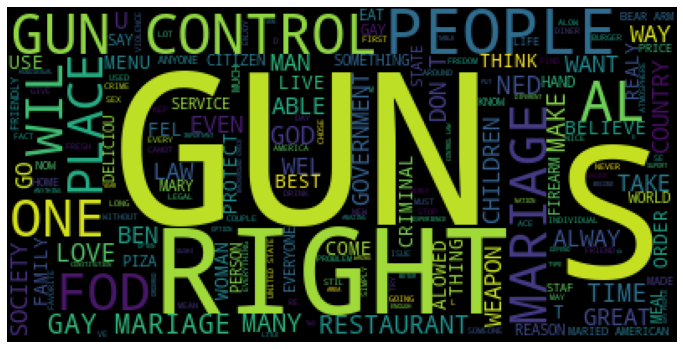

In [91]:
wordcloud = WordCloud().generate(text)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off");

## Modeling

We will try four predictive models: linear regression, a decision tree regressor, a bagging regressor, and a random forest regressor.

In [92]:
X = data['sentence']
y = data['type_time']

In [93]:
y

0        43693
1        34515
2        23272
3        15389
4        14949
         ...  
32706     3528
32707     3424
32708     3062
32709     3143
32710     3353
Name: type_time, Length: 32711, dtype: int64

In [94]:
# Baseline RMSE
mean_squared_error(y, [y.mean()]*len(y))

66966788.440797895

In [95]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [96]:
cv = CountVectorizer(min_df = 33)
Xcv_train = cv.fit_transform(X_train)
Xcv_test = cv.transform(X_test)

In [97]:
Xcv_train_df = pd.DataFrame(Xcv_train.todense(), columns = cv.get_feature_names())
Xcv_test_df = pd.DataFrame(Xcv_test.todense(), columns = cv.get_feature_names())

In [98]:
Xcv_train_df.shape

(26168, 1227)

In [99]:
lr = LinearRegression()

In [100]:
lr.fit(Xcv_train_df, y_train)

LinearRegression()

In [101]:
lr.score(Xcv_train_df, y_train)

0.7193947817532783

In [102]:
lr.score(Xcv_test_df, y_test)

0.6729243389396933

In [103]:
preds = lr.predict(Xcv_test_df)

# RMSE for linear regression
mean_squared_error(y_test, preds)**0.5

4695.739442454166

In [104]:
dtr = DecisionTreeRegressor()

In [105]:
dtr.fit(Xcv_train_df, y_train)

DecisionTreeRegressor()

In [106]:
dtr.score(Xcv_train_df, y_train)

0.9989140173185092

In [107]:
dtr.score(Xcv_test_df, y_test)

0.3713351691560923

In [108]:
preds = dtr.predict(Xcv_test_df)

# RMSE for decision tree regressor
mean_squared_error(y_test, preds)**0.5

6510.126979933639

In [109]:
br = BaggingRegressor()

In [110]:
br.fit(Xcv_train_df, y_train)

BaggingRegressor()

In [111]:
br.score(Xcv_train_df, y_train)

0.9262257789344067

In [112]:
br.score(Xcv_test_df, y_test)

0.5914834460859824

In [113]:
preds = br.predict(Xcv_test_df)

# RMSE for bagging regressor
mean_squared_error(y_test, preds)**0.5

5247.889799216346

In [114]:
rfr = RandomForestRegressor()

In [115]:
rfr.fit(Xcv_train_df, y_train)

RandomForestRegressor()

In [116]:
rfr.score(Xcv_train_df, y_train)

0.9469343412763238

In [117]:
rfr.score(Xcv_test_df, y_test)

0.6248504845286804

In [118]:
preds = rfr.predict(Xcv_test_df)

# RMSE for random forest
mean_squared_error(y_test, preds)**0.5

5029.00505039547

All four models used have a much better root mean squared error than the baseline, but the three tree models have very high variance. The linear model is the best for predicting the effect of words on typing time due to its low variance, though it still has only above-average accuracy.

In [119]:
coef = pd.DataFrame(lr.coef_, columns=['coef'], index=Xcv_train_df.columns)

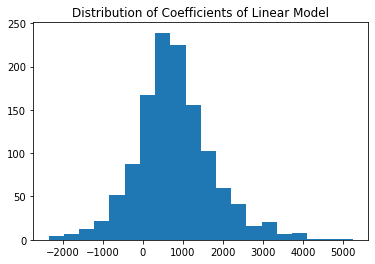

In [120]:
plt.hist(coef['coef'], bins=20)
plt.title("Distribution of Coefficients of Linear Model");

In [121]:
coef.sort_values('coef', ascending = False).head(10)

,coef
thethe,5236.839645
tha,4779.606841
health,4112.204173
consenting,4038.344118
sandy,3991.671240
wouldn,3933.510790
hte,3906.680230
fof,3900.008658
considering,3811.833368
walked,3754.875658


In [122]:
coef.sort_values('coef').head(10)

,coef
stable,-2354.142385
adopt,-2331.013287
shal,-2095.390774
included,-2073.101496
goten,-1931.585819
front,-1922.481181
list,-1752.665929
cream,-1741.212087
piece,-1643.965238
hands,-1603.929889


It is interesting that four of the words with the highest coefficients in the model are misspelled ("thethe," "tha," "hte," and "fof") while only two of the words with the lowest coefficients are ("shal" and "goten"). We should see if a higher number of misspelled words lead to longer typing times.

In [123]:
# di contains only real English words
di = enchant.Dict("en-US")

# We want to keep only the false words
for column in Xcv_train_df.columns:
    if di.check(column):
        Xcv_train_df.drop(columns = column, inplace = True)
        Xcv_test_df.drop(columns = column, inplace = True)

In [124]:
lr_false = LinearRegression()
lr_false.fit(Xcv_train_df, y_train)
lr_false.score(Xcv_train_df, y_train)

0.19843366698570208

In [125]:
lr_false.score(Xcv_test_df, y_test)

0.18040476516506776

Due to the poor accuracy scores in the linear regression model if we only used misspelled or false words, it is clear that the number of misspelled words does not explain the variance in typing times much at all.

In [126]:
X_transformed = cv.transform(X)
X_transformed_df = pd.DataFrame(X_transformed.todense(), columns = cv.get_feature_names())

# We will put the 10 most important words into our final dataframe
for word in ['thethe', 'tha', 'health', 'consenting', 'sandy', 'wouldn', 'hte', 'fof', 'considering', 'walked']:
    data[word] = X_transformed_df[word]

In [127]:
data.to_csv('../data/data_with_words.csv')